# Train a model on Parkinson telemonitoring data

## Make necessary imports

In [1]:
#pip install -r requirements.txt
%load_ext autoreload
%autoreload 2

In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings("ignore")

## Retrieve data 
With fetch ucirepo, and if it doesn't work read the local file `parkinsons_updrs.data`

In [156]:
try :
    from ucimlrepo import fetch_ucirepo 
  
    # fetch dataset 
    dataset = fetch_ucirepo(id=189)
    data = pd.concat([dataset.data.ids, dataset.data.features], axis=1)

except :
    def load_parkinson_updrs_data(data_file_path):
        df = pd.read_csv(data_file_path)

        target_columns = ['total_UPDRS', 'motor_UPDRS']
        target_df = df[target_columns]
        feature_df = df.drop(columns=target_columns)

        return {
            'data': {
                'features': feature_df,
                'targets': target_df
            },
            'feature_names': feature_df.columns.tolist(),
            'target_names': target_df.columns.tolist()
        }

    dataset = load_parkinson_updrs_data('../../parkinsons_updrs.data')
    data = dataset['data']['features']

X = data.drop(columns=["subject#", "test_time"], errors="ignore")
y = dataset['data']['targets']

In [157]:
y_motor = y.motor_UPDRS	
y_total = y.total_UPDRS

In [158]:
df = pd.concat([X, y], axis=1)
df

,age,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,Shimmer,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE,sex,motor_UPDRS,total_UPDRS
0,72,0.00662,0.000034,0.00401,0.00317,0.01204,0.02565,0.230,0.01438,0.01309,0.01662,0.04314,0.014290,21.640,0.41888,0.54842,0.16006,0,28.199,34.398
1,72,0.00300,0.000017,0.00132,0.00150,0.00395,0.02024,0.179,0.00994,0.01072,0.01689,0.02982,0.011112,27.183,0.43493,0.56477,0.10810,0,28.447,34.894
2,72,0.00481,0.000025,0.00205,0.00208,0.00616,0.01675,0.181,0.00734,0.00844,0.01458,0.02202,0.020220,23.047,0.46222,0.54405,0.21014,0,28.695,35.389
3,72,0.00528,0.000027,0.00191,0.00264,0.00573,0.02309,0.327,0.01106,0.01265,0.01963,0.03317,0.027837,24.445,0.48730,0.57794,0.33277,0,28.905,35.810
4,72,0.00335,0.000020,0.00093,0.00130,0.00278,0.01703,0.176,0.00679,0.00929,0.01819,0.02036,0.011625,26.126,0.47188,0.56122,0.19361,0,29.187,36.375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5870,61,0.00406,0.000031,0.00167,0.00168,0.00500,0.01896,0.160,0.00973,0.01133,0.01549,0.02920,0.025137,22.369,0.64215,0.55314,0.21367,0,22.485,33.485
5871,61,0.00297,0.000025,0.00119,0.00147,0.00358,0.02315,0.215,0.01052,0.01277,0.01904,0.03157,0.011927,22.886,0.52598,0.56518,0.12621,0,21.988,32.988
5872,61,0.00349,0.000025,0.00152,0.00187,0.00456,0.02499,0.244,0.01371,0.01456,0.01877,0.04112,0.017701,25.065,0.47792,0.57888,0.14157,0,21.495,32.495
5873,61,0.00281,0.000020,0.00128,0.00151,0.00383,0.01484,0.131,0.00693,0.00870,0.01307,0.02078,0.007984,24.422,0.56865,0.56327,0.14204,0,21.007,32.007


### Explore data

   age  Jitter(%)  Jitter(Abs)  Jitter:RAP  Jitter:PPQ5  Jitter:DDP  Shimmer  \
0   72    0.00662     0.000034     0.00401      0.00317     0.01204  0.02565   
1   72    0.00300     0.000017     0.00132      0.00150     0.00395  0.02024   
2   72    0.00481     0.000025     0.00205      0.00208     0.00616  0.01675   
3   72    0.00528     0.000027     0.00191      0.00264     0.00573  0.02309   
4   72    0.00335     0.000020     0.00093      0.00130     0.00278  0.01703   

   Shimmer(dB)  Shimmer:APQ3  Shimmer:APQ5  Shimmer:APQ11  Shimmer:DDA  \
0        0.230       0.01438       0.01309        0.01662      0.04314   
1        0.179       0.00994       0.01072        0.01689      0.02982   
2        0.181       0.00734       0.00844        0.01458      0.02202   
3        0.327       0.01106       0.01265        0.01963      0.03317   
4        0.176       0.00679       0.00929        0.01819      0.02036   

        NHR     HNR     RPDE      DFA      PPE  sex  motor_UPDRS  total_UP

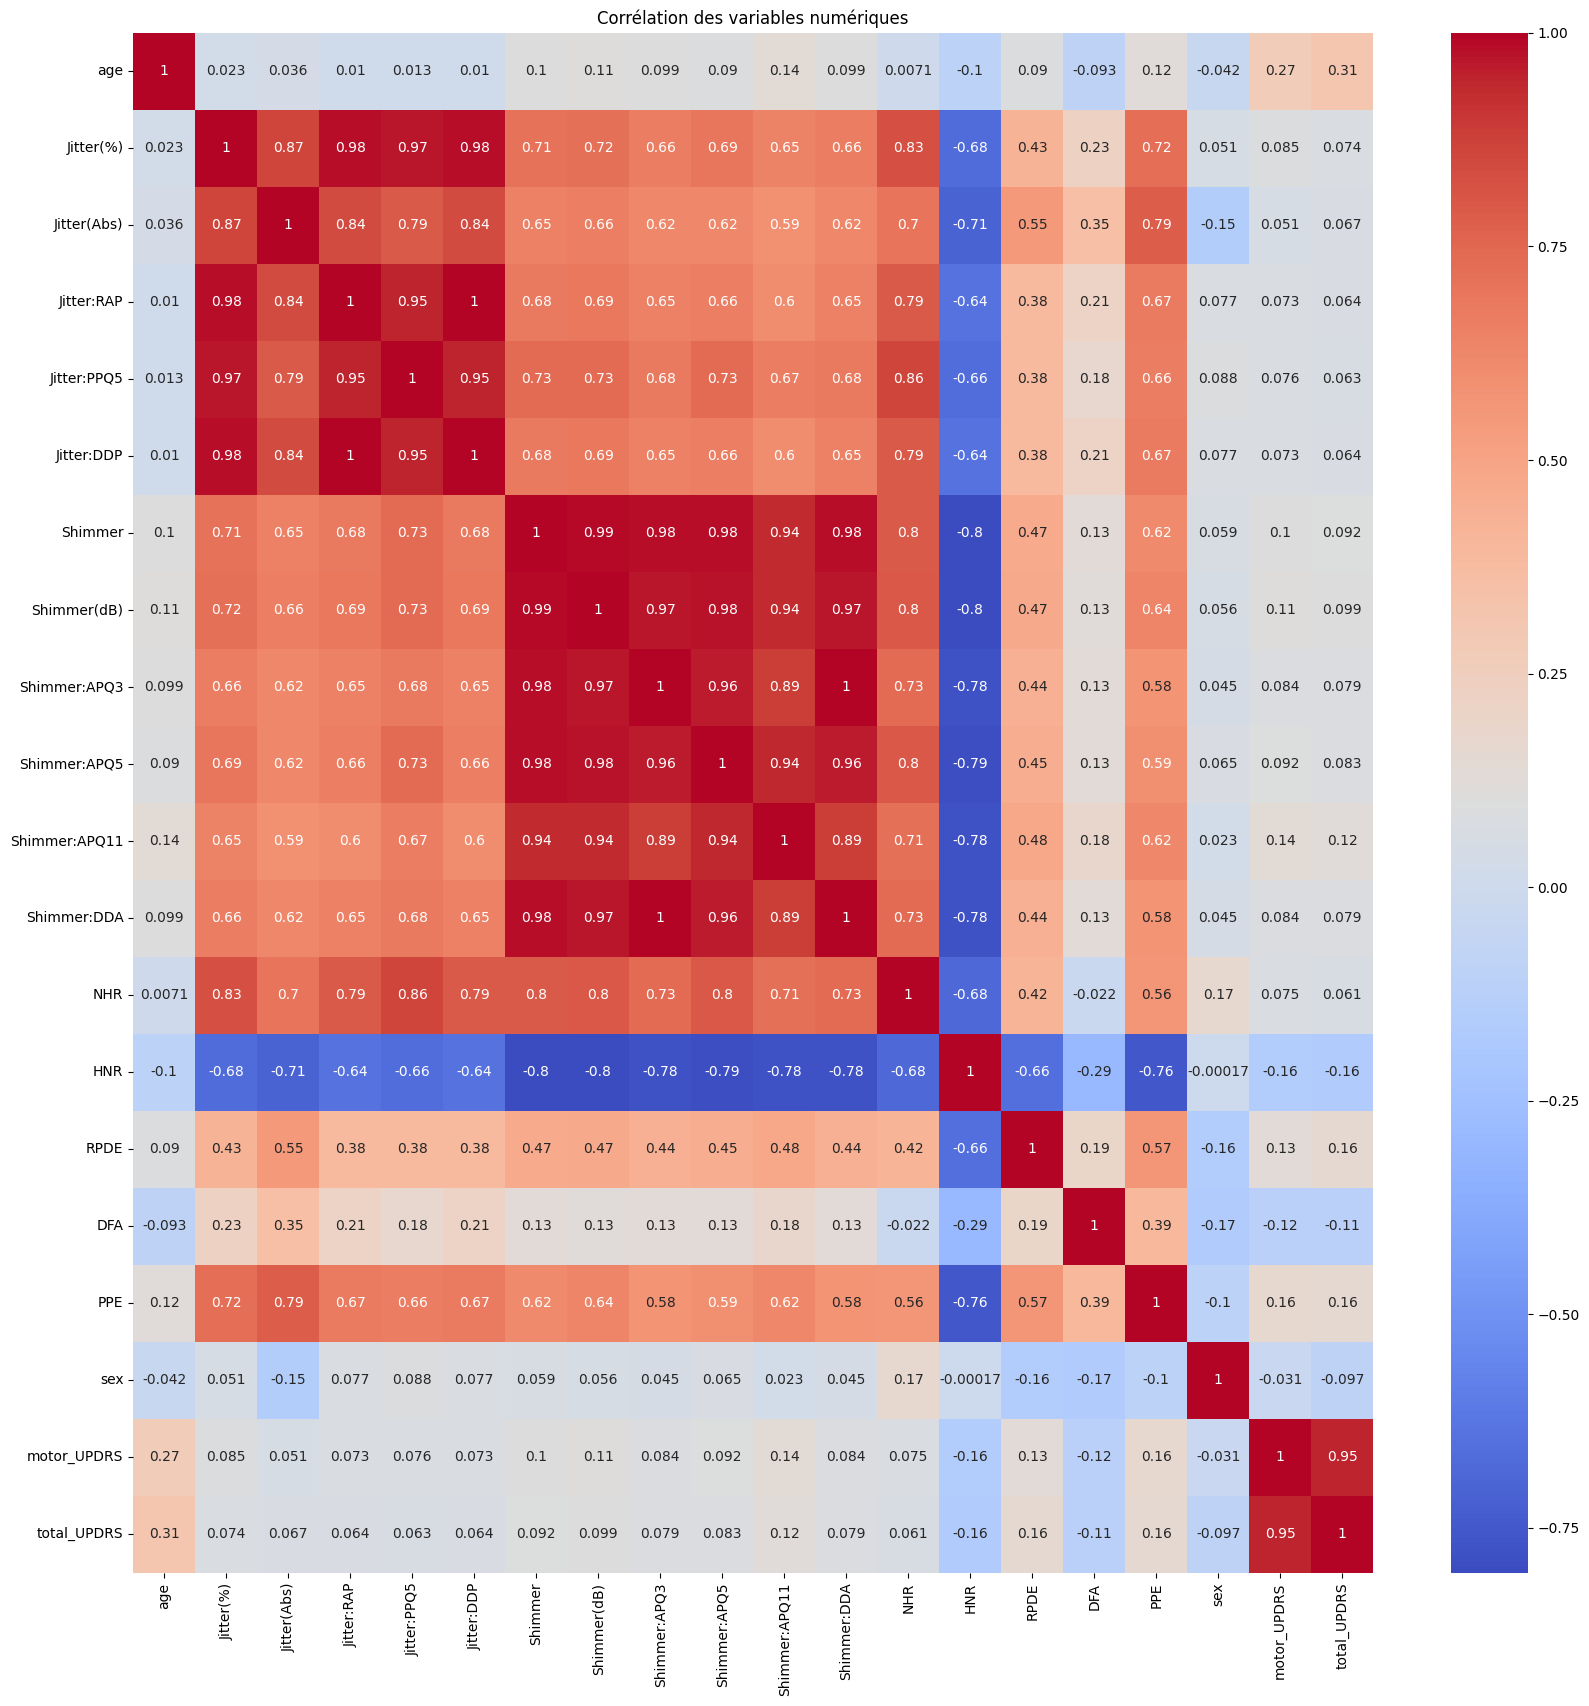

In [159]:
# Exploration minimale
print(df.head())
print(df.info())
print(df.describe())

plt.figure(figsize=(20,20))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Corrélation des variables numériques")
plt.show()

Text(0.5, 1.0, 'Hist for variable age')

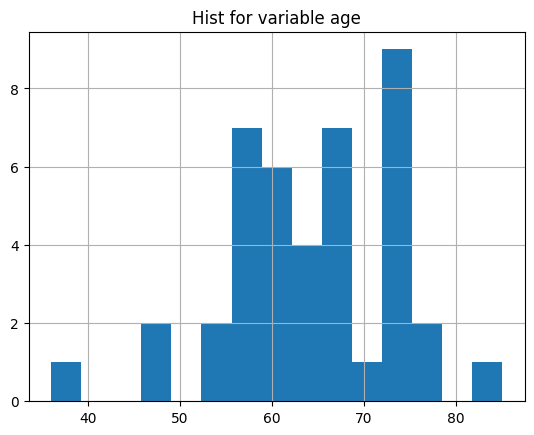

In [229]:
pd.concat([data[["subject#", "age"]], y], axis=1).groupby("subject#").mean().age.hist(bins=15)
plt.title("Hist for variable age")

Text(0, 0.5, 'total UPDRS')

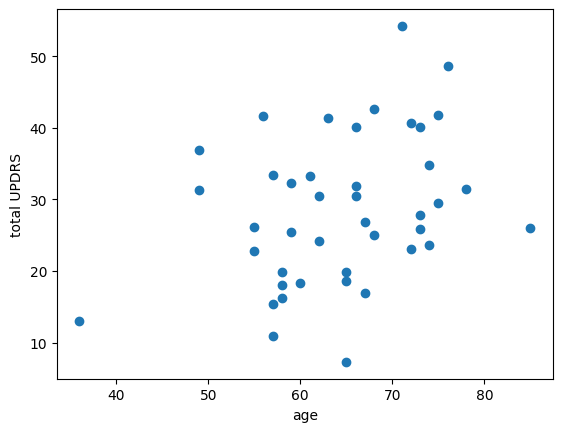

In [228]:
plt.scatter(pd.concat([data[["subject#", "age"]], y], axis=1).groupby("subject#").mean().age, pd.concat([data[["subject#", "age"]], y], axis=1).groupby("subject#").mean().total_UPDRS)
plt.xlabel("age")
plt.ylabel("total UPDRS")

In [160]:
# Prétraitement : uniquement numérique, donc normalisation
preprocessor = ColumnTransformer([
    ('scaler', StandardScaler(), X.columns)
])

In [161]:
# Modèles à tester
models = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=2000, max_depth=2, eta=0.06, random_state=42, max_leaves=0, subsample=0.9, colsample_bytree=0.19),
    'DecisionTree': DecisionTreeRegressor(),
}

In [164]:
# Split des données
lines_test = data[data["subject#"].isin(np.arange(1,42, 5))].index
lines_train = data[~data["subject#"].isin(np.arange(1,42, 5))].index
X_test = X.loc[lines_test]
X_train = X.loc[lines_train]
y_train = y_motor.loc[lines_train]
y_test = y_motor.loc[lines_test]
X_train, X_test, y_train, y_test = train_test_split(X, y_motor, test_size=0.2, random_state=42)

# Entraînement et évaluation
trained_models = {}

for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    print(f"\n=== {name} ===")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")
    print(f"R² Score: {r2_score(y_test, y_pred):.2f}")
    
    trained_models[name] = pipeline


=== LinearRegression ===
RMSE: 7.51
R² Score: 0.12

=== RandomForest ===
RMSE: 2.38
R² Score: 0.91

=== XGBoost ===
RMSE: 4.15
R² Score: 0.73

=== DecisionTree ===
RMSE: 3.46
R² Score: 0.81


## Modèles intrinsèquement explicables

### DecisionTree

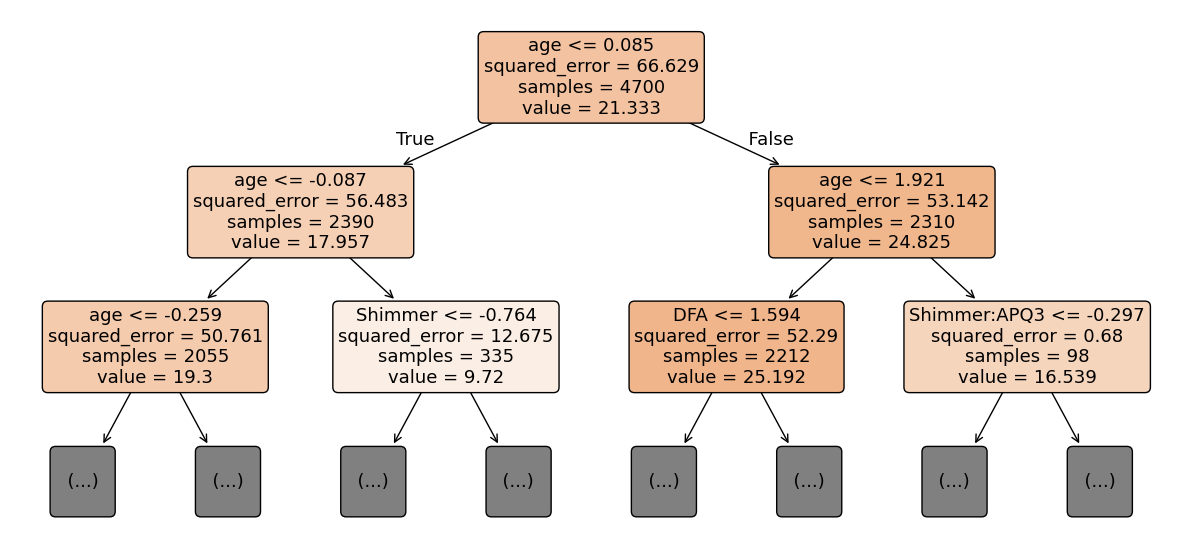

In [165]:
from sklearn.tree import plot_tree

plt.figure(figsize=(15,7))
plot_tree(models["DecisionTree"], feature_names=X_train.columns, filled=True, rounded=True, max_depth=2, fontsize=13)
plt.show()

In [166]:
from interpret.glassbox import ExplainableBoostingRegressor

ebm = ExplainableBoostingRegressor()
ebm.fit(X_train, y_train)

# Prédiction des classes sur le jeu de test
y_pred = ebm.predict(X_test)

# Calcul du F1-score (macro, micro ou weighted selon ton besoin)
score = r2_score(y_test, y_pred)  # ou 'macro' ou 'micro'
print(score)

0.8546131268029148


In [167]:
import matplotlib.pyplot as plt
from interpret import show

# Importance globale des features
ebm_global = ebm.explain_global()

show(ebm_global)

<!-- http://127.0.0.1:7001/2090729422336/ -->

In [168]:
ebm_local = ebm.explain_local(X_test, y_test)

show(ebm_local)

<!-- http://127.0.0.1:7001/2091967968848/ -->

# Explicabilité globale

Le Random Forest ayant les meilleures performances, nous allons appliquer le modèle RandomForestRegressor

In [170]:
preprocessor = ColumnTransformer([
    ('scaler', StandardScaler(), X.columns)
])

model = RandomForestRegressor(n_estimators=100, random_state=42)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', model)
])

X_train, X_test, y_train, y_test = train_test_split(X, y_total, test_size=0.2, random_state=42)

pipeline.fit(X_train, y_train)

X_train_transformed = pipeline["preprocessor"].transform(X_train)
X_test_transformed = pipeline["preprocessor"].transform(X_test)

y_pred = pipeline.predict(X_test)
print(f"Random Forest Regressor - RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")
print(f"Random Forest Regressor - R² Score: {r2_score(y_test, y_pred):.2f}")

Random Forest Regressor - RMSE: 2.97
Random Forest Regressor - R² Score: 0.92


## Explicabilité SHAP

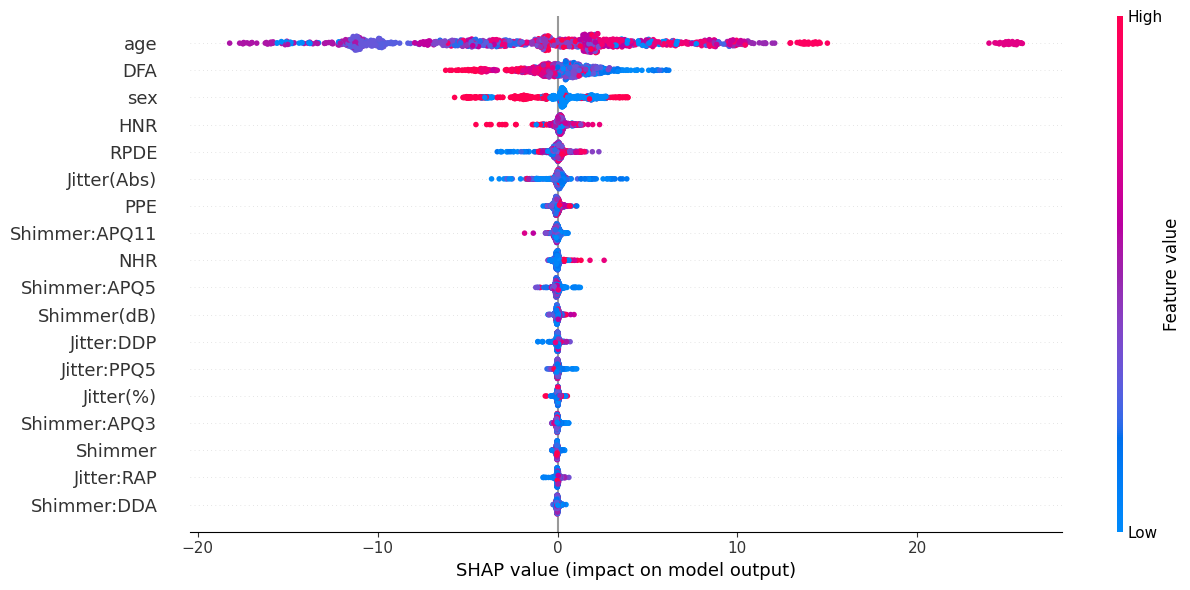

In [171]:
import shap

explainer = shap.Explainer(model)
shap_values = explainer(X_test_transformed)

shap.summary_plot(shap_values, features=X_test_transformed, feature_names=X.columns, plot_size=(13,6))

In [173]:
from saan_xai.shap import interactive_force_plot

interactive_force_plot(model, X_test)

interactive(children=(IntSlider(value=0, continuous_update=False, description='Index:', max=1174), Output()), …

In [ ]:
from shapash import SmartExplainer

xpl = SmartExplainer(
    model=model,
    # features_dict=house_dict,  # Optional parameter
    # preprocessing=encoder,  # Optional: compile step can use inverse_transform method
    # postprocessing=postprocess,  # Optional: see tutorial postprocessing
)

xpl.compile(
    x=X_test,
    y_pred=pd.Series(y_pred, index=y_test.index),  # Optional: for your own prediction (by default: model.predict)
    y_target=y_test,  # Optional: allows to display True Values vs Predicted Values
)

xpl.plot.features_importance()

app = xpl.run_app()

## Explicabilité Partial Dependency Plot

Le PdP peut directement prendre une pipeline en paramètre, pas besoin d'utiliser `X_train_transformed` et `X_test_transformed`

In [ ]:
from saan_xai.pdp import plot_partial_dependence_interactive

plot_partial_dependence_interactive(
    pipeline=pipeline,
    X_test=X_test,
    features=list(X.columns),
    kind="average",
    grid_resolution=50,
    figsize=(7,4)
)

interactive(children=(Dropdown(description='Feature:', layout=Layout(width='300px'), options=('age', 'Jitter(%…

Output()

In [ ]:
import numpy as np
from pdpbox import pdp, info_plots


# ----------------------
# PDP 1D et ICE pour une seule feature
# ----------------------

feature_to_plot = 'HNR'

pdp_iso = pdp.PDPIsolate(
    model=trained_models["RandomForest"],
    df=X,
    model_features=X.columns.tolist(),
    feature=feature_to_plot,
    feature_name=feature_to_plot,
    n_classes=0,
    num_grid_points=50
)

fig, axes = pdp_iso.plot(
    center=True,
    plot_lines=False,
    frac_to_plot=100,
    show_percentile=True,
    figsize=None,
    dpi=300,
    ncols=2,
    plot_params={"pdp_hl": True},
)
fig

obtain pred_func from the provided model.


  0%|          | 0/50 [00:00<?, ?it/s]

In [176]:
predict_school_holiday = info_plots.PredictPlot(
    model=trained_models["RandomForest"],
    df=X,
    model_features=X.columns.tolist(),
    feature="age",
    feature_name="age",
    pred_func=None,
    n_classes=0,
    predict_kwds={},
    chunk_size=-1,
    num_grid_points=15
)

fig, axes, summary_df = predict_school_holiday.plot(
    figsize=(1000,800),
    plot_params={"gaps": {"inner_y": 0.05}},
)
fig

obtain pred_func from the provided model.


## Prédiction ALE

Pour la prédiction ALE, deux librairies sont testées et comparées : `PyALE`et `alibi`

### PyALE

La librairie PyALE peut directement recevoir en input une pipeline sklearn, ce qui évite de devoir décomposer les étapes de la pipeline.

L'affichage d'un intervalle de confiance est également possible via les paramètres `include_CI`et `C`.

In [ ]:
from saan_xai.ale import plot_ale_interactive

plot_ale_interactive(
    model=pipeline,
    X_test=X_test,
    features=None,  # None pour toutes
    grid_size=50,
    include_CI=True,
    C=0.95,
    figsize=(10, 6)
)

interactive(children=(Dropdown(description='Feature:', layout=Layout(width='300px'), options=('age', 'Jitter(%…

Output()

### Alibi

Avec Alibi, nous devons décomposer notre objet pipeline, car il ne prend que les modèles sklearn.

De plus, le package alibi ne prend pas en charge l'affichage des intervalles de confiance, ou la distribution des différentes features.

Enfin, pour pouvoir l'importer, il vous faut une version de numpy inférieur à 2, ce qui peut être contraignant sur le reste de votre projet.

In [178]:
from saan_xai.ale import plot_alibi_ale_interactive

plot_alibi_ale_interactive(
    model=pipeline["regressor"],
    X_test=pipeline["preprocessor"].transform(X_test),
    features=X_test.columns,  # or None for all features if X_test is a dataframe
    figsize=(10,6)
)

interactive(children=(Dropdown(description='Feature:', layout=Layout(width='300px'), options=('age', 'Jitter(%…

Output()

## LOFO

In [180]:
from lofo import LOFOImportance, Dataset, plot_importance, FLOFOImportance

  0%|          | 0/18 [00:00<?, ?it/s]

Text(0.5, 1.0, 'LOFO importance Parkinson telemonitoring data')

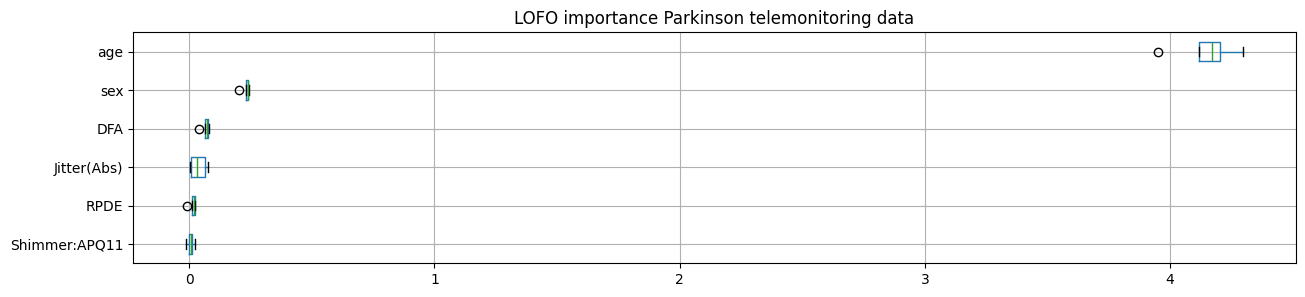

In [181]:
from sklearn.model_selection import KFold
cv = KFold(n_splits=4, shuffle=True, random_state=42)
dataset = Dataset(df=df, target="total_UPDRS", features=[col for col in df.columns if col not in ["total_UPDRS", "motor_UPDRS"]])

lofo_imp = LOFOImportance(dataset, 
                          cv=cv, 
                          model=RandomForestRegressor(n_estimators=100, random_state=42), 
                          scoring="neg_mean_absolute_error")

# get the mean and standard deviation of the importances in pandas format
importance_df = lofo_imp.get_importance()

plot_importance(importance_df.iloc[0:6], figsize=(15, 3), kind="box")
plt.title("LOFO importance Parkinson telemonitoring data")

  0%|          | 0/18 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Fast-LOFO importance Parkinson telemonitoring data')

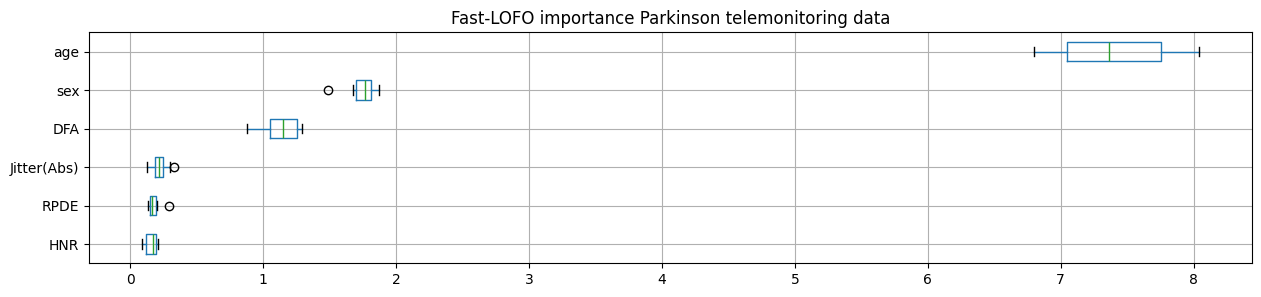

In [182]:
flofo_imp = FLOFOImportance(trained_model=pipeline, validation_df=pd.concat([X_test, y_test], axis=1), 
                           features=X_test.columns,
                           target = "total_UPDRS",
                           scoring="neg_mean_absolute_error")

# get the mean and standard deviation of the importances in pandas format
importance_df2 = flofo_imp.get_importance()

plot_importance(importance_df2.iloc[0:6], figsize=(15,3), kind="box")
plt.title("Fast-LOFO importance Parkinson telemonitoring data")

### **Local Methods**

#### **Lime** - Local

In [ ]:
from saan_xai.lime import interactive_lime_explanation

interactive_lime_explanation(model, X_train, mode="regression")

interactive(children=(IntSlider(value=0, continuous_update=False, description='Index:', max=4699), Output()), …

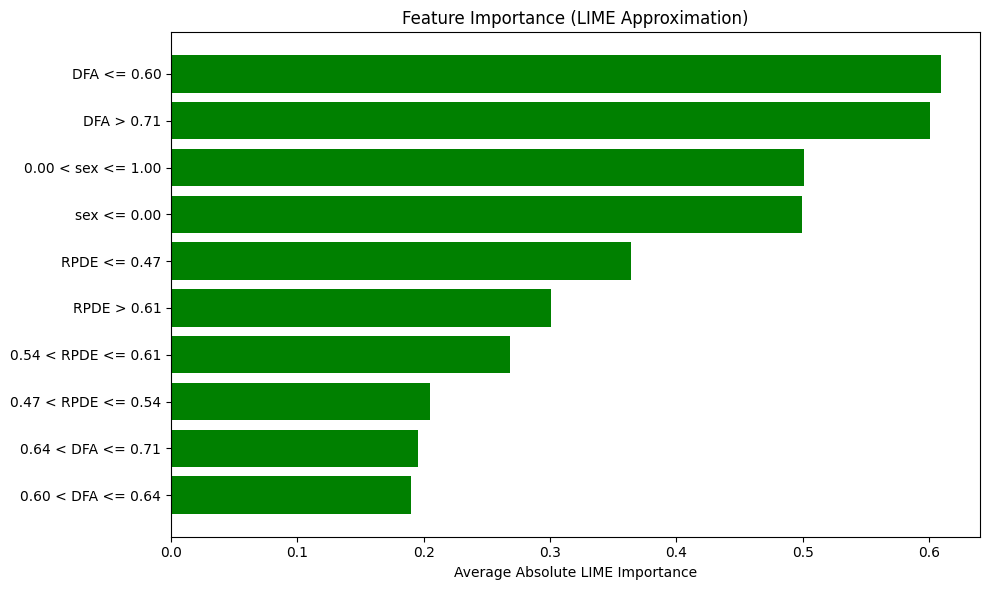

In [ ]:
from collections import defaultdict
from lime.lime_tabular import LimeTabularExplainer

instance_idx = 2  # Indice de l'instance à expliquer
instance = X_test.values[instance_idx]

# Création de l'explainer LIME
explainer = LimeTabularExplainer(
    X_train.values,
    mode='regression',
    feature_names=X_train.columns.values.tolist(),  
    verbose=False,
)

importance_scores = defaultdict(list)

for i in range(len(X_test)):  # or more samples
    exp = explainer.explain_instance(X_test.iloc[i], model.predict)
    for feature, weight in exp.as_list():
        importance_scores[feature].append(abs(weight))

# Compute average importance
avg_importance = {k: np.mean(v) for k, v in importance_scores.items()}
sorted_importance = sorted(avg_importance.items(), key=lambda x: -x[1])

# Sort and plot
sorted_items = sorted(avg_importance.items(), key=lambda x: -x[1])
features, importances = zip(*sorted_items[:10])

plt.figure(figsize=(10, 6))
plt.barh(features[::-1], importances[::-1], color='green')
plt.xlabel("Average Absolute LIME Importance")
plt.title("Feature Importance (LIME Approximation)")
plt.tight_layout()
plt.show()

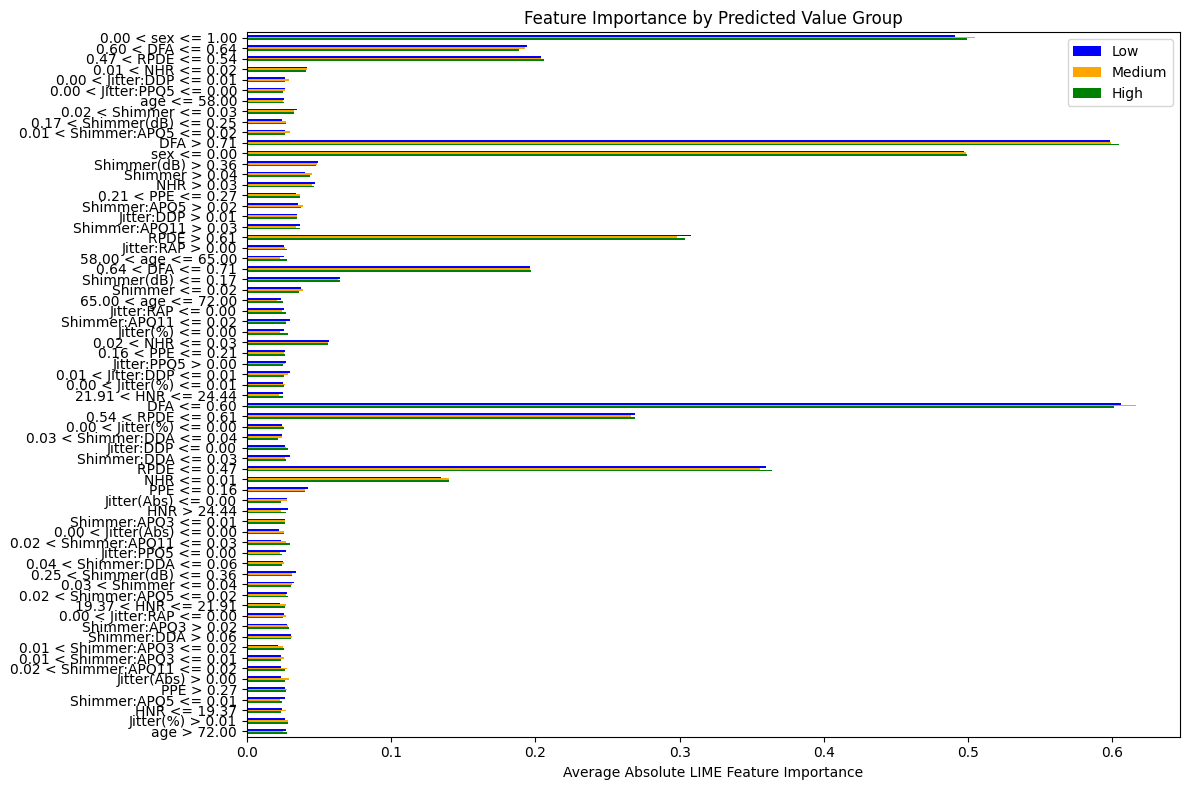

In [225]:
from lime.lime_tabular import LimeTabularExplainer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict


# Convert predictions list to numpy array
predictions = np.array(y_pred)

# Example: Group feature importances by predicted value bins
bins = [predictions.min(), np.percentile(predictions, 33), np.percentile(predictions, 66), predictions.max()+1]
labels = ['Low', 'Medium', 'High']

importance_by_group = {label: defaultdict(list) for label in labels}

for i, pred in enumerate(predictions):
    for bin_min, bin_max, label in zip(bins[:-1], bins[1:], labels):
        if bin_min <= pred < bin_max:
            exp = explainer.explain_instance(X_test.values[i], model.predict, num_features=10)
            for feature, weight in exp.as_list():
                importance_by_group[label][feature].append(abs(weight))
            break

# Calculate average importance per feature per group
avg_importance_by_group = {
    group: {feat: np.mean(weights) for feat, weights in feats.items()}
    for group, feats in importance_by_group.items()
}

# Convert to DataFrame for plotting (filling missing features with 0)
df_importance = pd.DataFrame(avg_importance_by_group).fillna(0)

# Plot feature importance per group
df_importance.plot.barh(figsize=(12, 8), color=['blue', 'orange', 'green'])
plt.xlabel('Average Absolute LIME Feature Importance')
plt.title('Feature Importance by Predicted Value Group')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Also, display the explanation for your initial instance
instance_idx = 2
instance = X_test.values[instance_idx]
exp = explainer.explain_instance(instance, model.predict)

from IPython.display import display, HTML
display(HTML('''
    <style>
        .lime {
            background-color: white !important;
        }
    </style>
'''))

exp.show_in_notebook()

#### **ICE** - Local

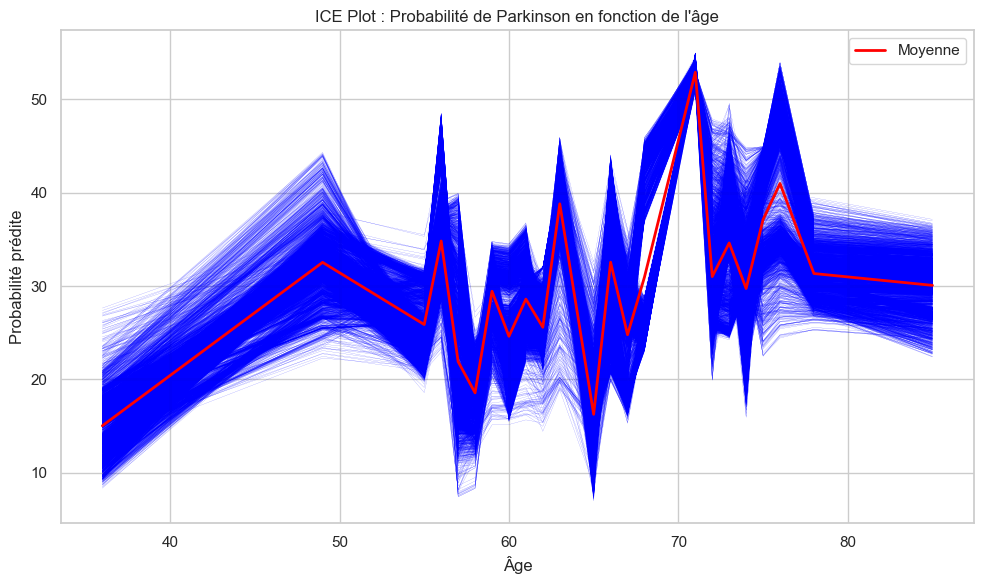

In [ ]:
from sklearn.inspection import partial_dependence

# 1. Compute the partial dependence (ICE and average) manually
results = partial_dependence(model, X_train_transformed, features=[0], kind="both", grid_resolution=50)

# Extract values
feature_vals = results['grid_values'][0]
ice_lines = results['individual'][0]   # shape (n_samples, n_grid_points)
average_line = results['average'][0]   # shape (n_grid_points,)

# 2. Plot with Seaborn style
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

# Plot ICE lines
for row in ice_lines:
    plt.plot(feature_vals, row, color='blue', alpha=0.8, linewidth=0.1)

# Plot average (PDP) line in a different color
plt.plot(feature_vals, average_line, color='red', label='Moyenne', linewidth=2)

# 3. Label and show
plt.title("ICE Plot : Probabilité de Parkinson en fonction de l'âge")
plt.xlabel("Âge")
plt.ylabel("Probabilité prédite")
plt.legend()
plt.tight_layout()
plt.show()

#### Comparaison **Pdp** and Average **ICE**


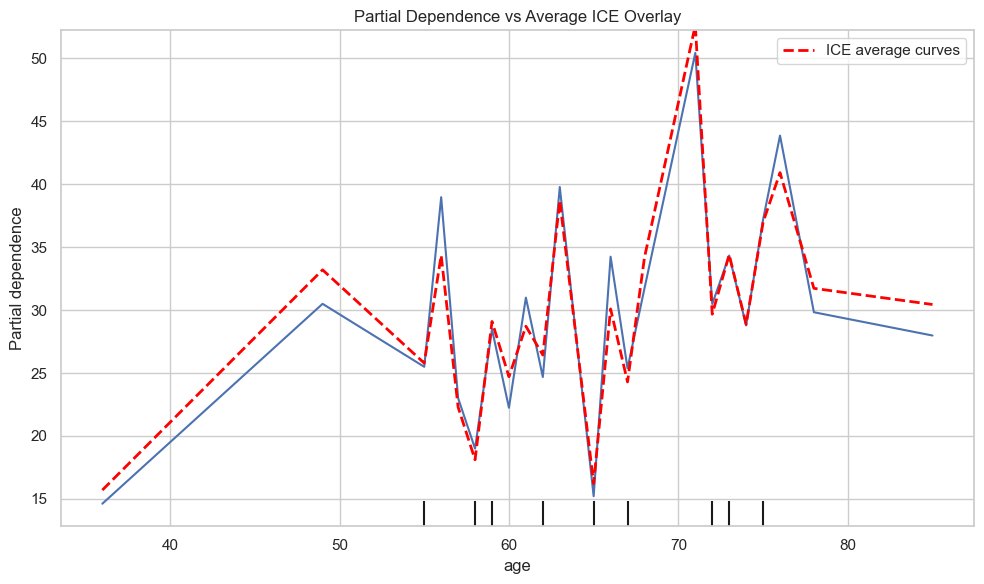

In [ ]:
from sklearn.inspection import PartialDependenceDisplay, partial_dependence

# Step 1: Plot PDP from pipeline
fig, ax = plt.subplots(figsize=(10, 6))
disp = PartialDependenceDisplay.from_estimator(
    pipeline,
    X_test,
    features=[0],  # single feature
    kind="average",
    grid_resolution=150,
    ax=ax
)
ax = plt.gca()  # get current axis after display

# Step 2: Compute manual PDP from different model/data
results = partial_dependence(model, X_train_transformed, features=[0], kind="average", grid_resolution=150)
feature_vals = results['grid_values'][0]
average_line = results['average'][0]

# Step 3: Access the correct axis and overlay the manual PDP
# If ax is a single Axes object (which it is for one feature), use it directly
ax.plot(
    feature_vals,
    average_line,
    label='ICE average curves',
    color='red',
    linestyle='--',
    linewidth=2
)

# Step 4: Final plot formatting
ax.set_title("Partial Dependence vs Average ICE Overlay")
ax.legend()
plt.tight_layout()
plt.show()


#### **Anchors** - Local

For Anchors, we should turn the problem from a **regression** task to a **classification** one. 

In [226]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import recall_score, f1_score

# Binarize total_UPDRS (or your column name)
threshold = df['total_UPDRS'].median()
df['UPDRS_binary'] = (df['total_UPDRS'] > threshold).astype(int)

X_anc = df.drop(columns=['total_UPDRS', 'motor_UPDRS', 'UPDRS_binary'])  # drop targets
y_anc = df['UPDRS_binary']

# Split des données
X_train_anc, X_test_anc, y_train_anc, y_test_anc = train_test_split(X_anc, y_anc, test_size=0.2, random_state=42)

# Modèles à tester
models = {
    'LogisticRegression': LogisticRegression(),
    'RandomForest_Classifier': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost_Classifier': XGBClassifier(n_estimators=100, random_state=42)
}

# Entraînement et évaluation
trained_models = {}

for name, model in models.items():
    
    model.fit(X_train_anc, y_train_anc)
    y_pred = model.predict(X_test_anc)
    
    print(f"\n=== {name} ===")
    print(f"Recall score: {(recall_score(y_test_anc, y_pred)):.2f}")
    print(f"F1-Score: {f1_score(y_test_anc, y_pred):.2f}")
    
    trained_models[name] = model


=== LogisticRegression ===
Recall score: 0.60
F1-Score: 0.60

=== RandomForest_Classifier ===
Recall score: 0.92
F1-Score: 0.91

=== XGBoost_Classifier ===
Recall score: 0.93
F1-Score: 0.93


In [227]:
from alibi.explainers import AnchorTabular
rf_model_anc = trained_models['RandomForest_Classifier']
    
# Création de l'explicateur Anchors avec la fonction prédictive
explainer = AnchorTabular(predictor=rf_model_anc.predict, feature_names=X_train_anc.columns)

# Ajustement avec les données d'entraînement
explainer.fit(X_train_anc.to_numpy())

# Sélection d'une instance à expliquer
idx = 4  # Choix d'une instance arbitraire
instance = X_test_anc.iloc[idx].values

# Génération de l'explication avec Anchors
exp_anchor = explainer.explain(instance)

# Affichage de la règle d'ancrage trouvée
print("\n Règle d'ancrage trouvée :")
print(exp_anchor.anchor)
print(f'prediction :{exp_anchor.data['raw']['prediction'][0]}')
print(f" Précision de la règle : {exp_anchor.precision:.2f}")
print(f" Couverture de la règle : {exp_anchor.coverage:.2f}")

alibi.explainers.anchors.anchor_base:WARNING: Could not find an anchor satisfying the 0.95 precision constraint. Now returning the best non-eligible result. The desired precision threshold might not be achieved due to the quantile-based discretisation of the numerical features. The resolution of the bins may be too large to find an anchor of required precision. Consider increasing the number of bins in `disc_perc`, but note that for some numerical distribution (e.g. skewed distribution) it may not help.



 Règle d'ancrage trouvée :
['DFA <= 0.60', 'Shimmer:APQ11 > 0.03', '0.00 < sex <= 1.00', 'age <= 72.00', 'HNR <= 19.37', 'Shimmer:APQ3 > 0.02', 'Jitter:PPQ5 > 0.00', 'Shimmer(dB) > 0.36', 'NHR > 0.01', 'Shimmer > 0.04', 'Shimmer:APQ5 > 0.01', 'Shimmer:DDA > 0.06']
prediction :1
 Précision de la règle : 0.94
 Couverture de la règle : 0.02
